# Modelos de Mezcla (Mixture Models)

Un modelo de mezcla combina varios modelos de componente para generar un modelo más complejo. Esto se expresa como una combinación ponderada de distribuciones condicionales. En este caso, \( p(v) \) es la distribución total que describe los datos observados, \( v \), y se calcula sumando las distribuciones condicionales \( p(v|h) \), donde \( h \) es una variable oculta (o latente) que indexa diferentes componentes en el modelo.

## Aplicación en Clustering

En el contexto de clustering, cada componente \( h \) puede interpretarse como un "cluster" y \( p(h) \) como la probabilidad de que un punto de datos pertenezca a ese cluster. Al generar un punto de datos \( v \), primero se selecciona un cluster \( h \) según \( p(h) \), y luego se genera el valor de \( v \) condicionado en \( h \).

## Modelo de Mezcla de Bernoulli Independientes

Este modelo es útil para clústeres de vectores binarios. Los datos \( v_n = (v_{n1}, \dots, v_{nD}) \) son vectores de variables binarias (0 o 1), y el modelo se puede describir como una mezcla de distribuciones de Bernoulli. El aprendizaje de este modelo se hace mediante el algoritmo de Expectation Maximization (EM), que ajusta los parámetros de las distribuciones \( p(v_i|h) \) y las probabilidades de los clusters \( p(h) \).

## Algoritmo EM

Expectation Maximization (EM) es un algoritmo iterativo utilizado para encontrar estimaciones de máxima verosimilitud en modelos estadísticos con variables latentes. Se compone de dos pasos:

- **E-step (Expectativa)**: Estima la probabilidad posterior de las variables latentes \( h \) dado los datos observados \( v_n \).
- **M-step (Maximización)**: Actualiza los parámetros del modelo para maximizar la esperanza de la log-verosimilitud, usando las probabilidades obtenidas en el paso anterior.

## Modelo de Mezcla Gaussiana

Un modelo de mezcla gaussiana combina varias distribuciones normales (Gaussianas), cada una con su propia media (\( m_i \)) y matriz de covarianza (\( S_i \)). Es útil para modelar datos continuos, como distribuciones de puntos en el espacio.

El modelo de mezcla gaussiana se expresa como una suma ponderada de distribuciones normales, y la tarea es estimar los parámetros de las componentes gaussianas, como las medias, las covarianzas y las probabilidades de mezcla \( p(i) \).

## Maximum Likelihood

La log-verosimilitud del modelo de mezcla gaussiana se maximiza mediante el algoritmo EM. En este caso, el E-step implica calcular la probabilidad de que cada dato pertenezca a cada componente gaussiano, y el M-step actualiza los parámetros de las distribuciones gaussianas para maximizar la log-verosimilitud.

## Optimización de los Parámetros

Para el M-step, se calculan las actualizaciones para las medias \( m_i \) y las matrices de covarianza \( S_i \). Las medias se actualizan ponderando los datos con las probabilidades posteriores de los clusters, mientras que las matrices de covarianza se actualizan mediante una fórmula que involucra las diferencias cuadradas entre los puntos de datos y las medias.

## K-Means y Cuantificación Vectorial

K-Means es una técnica de clustering que puede considerarse como un caso específico de un modelo de mezcla gaussiana con covarianzas isotrópicas (igual en todas las direcciones). A medida que la varianza \( \sigma^2 \) tiende a cero, el algoritmo se comporta como si asignara determinísticamente cada punto al centroide más cercano, lo que se conoce como cuantificación vectorial. Esto se utiliza comúnmente para compresión de datos, donde en lugar de almacenar el punto de datos original, se almacena el índice del centroide al que pertenece.

## Problemas y Soluciones

Uno de los problemas en el ajuste de modelos de mezcla de gaussianas es el sobreajuste o la "explosión" de la verosimilitud, especialmente cuando las gaussianas tienen varianzas muy pequeñas. Para evitar esto, se puede añadir una restricción en el ancho de las distribuciones gaussianas para evitar que se conviertan en "singulares" (con varianza cero).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

## Mezcla de Bernoullis (ejemplo 20.2)

Hay que implementar el algoritmo EM para una mezcla de Bernoullis. Las actualizaciones de los parámetros (paso M) y de la distribución de las variables latentes (paso E) se encuentran en la sección 20.2.2 del libro.

De nuevo, la vectorización puede enturbiar las ideas básicas. Consideremos el paso E: $p^n(h=j|v^n) \propto p^o(h=j)\prod_{i=1}^D p^o(v_i^n|h=j)$. Nótese que se tiene una distribución por cada punto $v^n$ y la actualización, para cada una de ellas, sigue el mismo patrón. $v^n$ es un vector $(v_1^n,\dots,v_D^n)$, cuyas componentes valen $0$ o $1$, y el valor de $p(v_i^n|h=j)$ dependerá del valor concreto de $v_i^n$; conviene agrupar las componentes atendiendo a ese valor, definiendo st0 = (v[:,n] == np.zeros(D)) (y lo mismo para 1). Por otro lado, para evitar errores numéricos que podrían surgir con el producto de tantos valores pequeños, conviene trabajar con logaritmos.
$$
\log p^n(h=j|v^n) \propto \log p^o(h=j) + \sum_{v_i^n=1} \log p^o(v_i^n|h=j) + \sum_{v_i^n=0} \log p^o(v_i^n|h=j)
$$
Todos las probabilidades que aparecen en esa fórmula están a nuestra disposición y se trata de combinarlas con la ayuda de st0 y st1. Por último, esta fórmula trabaja con $h=j$; se podría tener un bucle que considere todos los posibles valores de $h$ pero es más eficiente vectorizarlo y calcular las probabilidades para todos los $h$ simultáneamente.

Un último detalle a tener en cuenta es permitir que puedan faltar datos (algunas de las componentes $v_i^n$), como se analizó en el ejercicio 20.1.

In [39]:
def MIXprodBern(v, H, opts):
    """
    MIXprodBern: Algoritmo EM para entrenar una mezcla de productos de distribuciones de Bernoulli.
    [ph, pvgh, loglik, phgv] = MIXprodBern(v, H, opts)
    
    Parámetros:
    v : Matriz de datos (cada columna es una muestra).
    H : Número de componentes en la mezcla.
    opts: Diccionario con parámetros adicionales:
        opts.maxit : Número máximo de iteraciones.
        opts.meaninit: Si 1, inicializar las probabilidades con las medias.

    Retorna:
    ph : p(h), probabilidades de los componentes.
    pvgh : p(v|h), probabilidades condicionales de las respuestas.
    loglik : Verosimilitud logarítmica del conjunto de datos en cada iteración.
    phgv : p(h|v), asignación posterior de los datos a los componentes de la mezcla.
    """

    # Dimensiones de los datos
    D, N = v.shape  # D: número de preguntas, N: número de respuestas (personas)

    # Inicialización de parámetros
    rng = np.random.default_rng()  # Generador de números aleatorios
    if opts['meaninit'] == 1:
        # Inicialización con las medias de los datos más un pequeño ruido aleatorio
        ph = np.ones(H) / H  # Inicialización uniforme de p(h)
        pvgh = v.mean(axis=1)[:, np.newaxis] + 0.001 * rng.random((D, H))
        pvgh = pvgh / pvgh.sum(axis=0)  # Normalizar para garantizar que sea una distribución válida
    else:
        # Inicialización aleatoria
        ph = rng.random(H)
        ph /= ph.sum()  # Normalizar para garantizar que sea una distribución válida
        pvgh = rng.random((D, H))
        pvgh /= pvgh.sum(axis=0)  # Normalizar por columnas

    # Preparar almacenamiento de la verosimilitud logarítmica
    lik = np.zeros(opts['maxit'])
    phgv = np.zeros((H, N))

    # Bucle de iteraciones EM
    for emloop in range(opts['maxit']):
        # Variables acumuladoras para el paso M
        htot = np.zeros(H)  # Contador de responsabilidades para cada componente
        vhtot1 = np.zeros((D, H))  # Acumulador para p(v_i=1|h)
        vhtot0 = np.zeros((D, H))  # Acumulador para p(v_i=0|h)
        loglik = 0  # Inicializar la verosimilitud logarítmica
D
        # Paso E: calcular responsabilidades
        for n in range(N):
            # Crear una máscara para los datos observados (no faltantes), los missing toman valor 0.5 en v
            observed = v[:, n] != 0.5
            v_n = v[:, n]

            # Calcular el logaritmo de p(v|h) para cada h
            log_p_v_given_h = np.zeros(H)
            for h in range(H):
                log_p_v_given_h[h] = np.log(ph[h]) \
                                     + np.sum(np.log(pvgh[observed, h]) * v_n[observed]) \
                                     + np.sum(np.log(1 - pvgh[observed, h]) * (1 - v_n[observed]))

            # Normalizar para evitar problemas numéricos(se hace asi siempre)
            phgv[:, n] = np.exp(log_p_v_given_h - logsumexp(log_p_v_given_h))

            # Acumular las responsabilidades para el paso M
            htot += phgv[:, n]
            vhtot1[:, :] += np.outer(v_n == 1, phgv[:, n])  # Acumular para respuestas iguales a 1
            vhtot0[:, :] += np.outer(v_n == 0, phgv[:, n])  # Acumular para respuestas iguales a 0

            # Actualizar la verosimilitud logarítmica
            loglik += logsumexp(log_p_v_given_h)

        # Paso M: actualizar los parámetros p(h) y p(v|h)
        ph = htot / htot.sum()  # Normalizar p(h)
        pvgh = vhtot1 / (vhtot1 + vhtot0)  # Actualizar p(v|h)

        # Guardar la verosimilitud de esta iteración
        lik[emloop] = loglik

    return ph, pvgh, lik, phgv

### Generación de datos.

150 entrevistados y 5 preguntas por encuesta. Se supone que hay dos tipos de entrevistados.

In [40]:
# Distribuciones reales.
ph_true = np.array([0.3, 0.7])
pvgh_true = np.array([[0.87, 0.82, 0.2, 0.22, 0.2], [0.2,  0.2, 0.82, 0.85, 0.19]]).T

# Crear generador de números.
rng = np.random.default_rng()

D = 5 # dimensión de cada muestra
customers = 150
noise = 0.25
max_miss = 2 # máximo número de valores que pueden faltar por muestra

# Inicializar arrays.
responses = np.zeros((D,customers))
h_sample = np.zeros(customers, dtype=int)

for n in range(customers):
    # Generar el estado latente.
    h_sample[n] = rng.choice(len(ph_true), p=ph_true)
    
    # Generar datos a partir de p(v|h)
    responses[:, n] = rng.random(D) < pvgh_true[:, h_sample[n]]

    # Simular datos que faltan.
    miss = rng.integers(max_miss + 1)  # número de entradas que faltan
    miss_indices = rng.choice(D, miss, replace=False)
    responses[miss_indices, n] = 0.5  # codificar dato que falta como 0.5

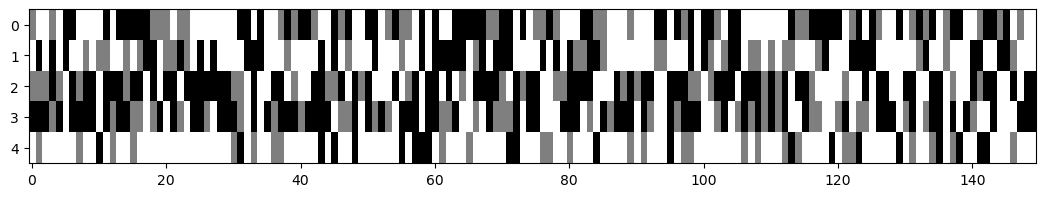

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (13,2))
ax.imshow(responses, aspect='auto', cmap='gray_r', interpolation='none')

Ejecutar EM para encontrar los dos tipos de entrevistados

In [42]:
opts = {"maxit" : 200,
        "meaninit" : 0,
       }

In [43]:
# Realizamos varias ejecuciones (para intentar evitar máximos locales):
nruns = 4
best_loglik = float('-inf')  # Guardar el mejor valor de log-verosimilitud
best_ph, best_pvgh, best_phgv = None, None, None  # Para almacenar los mejores resultados

for i in range(nruns):
    ph, pvgh, lik, phgv = MIXprodBern(responses, H=2, opts=opts)

    # Verificar si la ejecución actual es mejor
    if lik[-1] > best_loglik:
        best_loglik = lik[-1]  # Actualizar mejor log-verosimilitud
        best_ph = ph
        best_pvgh = pvgh
        best_phgv = phgv

# Resultados finales: ph, pvgh y phgv correspondientes a la mejor ejecución
print("Mejor log-verosimilitud:", best_loglik)
print("Mejores probabilidades p(h):", best_ph)
print("Mejores probabilidades p(v|h):", best_pvgh)

Mejor log-verosimilitud: -324.4351394301322
Mejores probabilidades p(h): [0.35568625 0.64431375]
Mejores probabilidades p(v|h): [[0.95393167 0.22434607]
 [0.71013237 0.17119137]
 [0.19731691 0.84100332]
 [0.08716422 0.910138  ]
 [0.26336076 0.11177333]]


In [44]:
ph, ph_true

(array([0.64431375, 0.35568625]), array([0.3, 0.7]))

Reordenamos los vectores en orden creciente de probabilidad de las variables latentes para facilitar la comparación gráfica con los valores reales.

In [45]:
sort_indices = np.argsort(ph)
ph_sorted = ph[sort_indices]
pvgh_sorted = pvgh[:,sort_indices]
phgv_sorted = phgv[sort_indices,:]

Comparemos el valor real de $p(v|h)$ (a la izquierda) con su aproximación (a la derecha). El color rojo representa la primera variable latente y el color verde, la otra.

<BarContainer object of 5 artists>

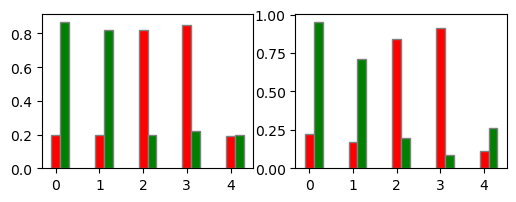

In [46]:
barWidth = 0.2
fig, axs = plt.subplots(1, 2, figsize =(6, 2)) 
  
# Set position of bar on X axis 
br1 = np.arange(len(pvgh_true[:,0])) 
br2 = [x + barWidth for x in br1] 
 
# Construir la figura
axs[0].bar(br1, pvgh_true[:,1], color ='r', width = barWidth, edgecolor ='grey') 
axs[0].bar(br2, pvgh_true[:,0], color ='g', width = barWidth, edgecolor ='grey')  

axs[1].bar(br1, pvgh_sorted[:,1], color ='r', width = barWidth, edgecolor ='grey') 
axs[1].bar(br2, pvgh_sorted[:,0], color ='g', width = barWidth, edgecolor ='grey')  

La primera subfigura muestra los valores correctos de h tal y como fueron muestreados. La tercera muestra la estimación $p(h^n=1|v^n)$.

<BarContainer object of 150 artists>

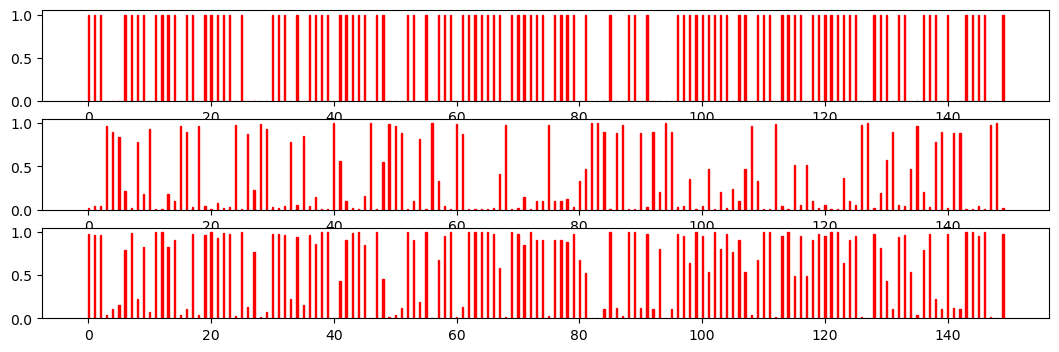

In [38]:
fig, axs = plt.subplots(3, 1, figsize = (13,4))

br1 = np.arange(len(h_sample)) 
axs[0].bar(br1, h_sample, color ='r', width = barWidth, edgecolor ='red') 
axs[1].bar(br1, phgv_sorted[0], color ='r', width = barWidth, edgecolor ='red')
axs[2].bar(br1, phgv_sorted[1], color ='r', width = barWidth, edgecolor ='red')